## KCC Meeting metadata EDA

In [503]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

# Load JSONL file into a DataFrame
file_path = '../data/meetings/meetings_metadata_new.jsonl'
data = pd.read_json(file_path, lines=True)

# Show basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455 entries, 0 to 2454
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   web_meeting_code   2455 non-null   int64         
 1   meeting_id         2455 non-null   object        
 2   scrape_timestamp   2455 non-null   object        
 3   error              637 non-null    object        
 4   meeting_title      1818 non-null   object        
 5   meeting_status     1818 non-null   object        
 6   committee_name     1818 non-null   object        
 7   meeting_date       1818 non-null   object        
 8   meeting_time       1818 non-null   datetime64[ns]
 9   agenda_items       1818 non-null   object        
 10  header_pdf_urls    1818 non-null   object        
 11  attached_pdfs      1818 non-null   float64       
 12  header_pdfs        1818 non-null   float64       
 13  total_pdfs_found   1818 non-null   float64       
 14  pdfs_una

#### Loading the metadata and examining the scraping results

In [504]:
# Show the first few rows
#data.head(1)

removing duplicates

In [505]:
# Find duplicated web_meeting_codes
duplicate_codes = data[data['web_meeting_code'].duplicated(keep=False)]

# Sort and select specific columns
duplicate_codes = duplicate_codes.sort_values('web_meeting_code')[
    ['web_meeting_code', 'scrape_timestamp', 'meeting_title', 'meeting_status', 'meeting_date']
]
duplicate_codes.head(10)

,web_meeting_code,scrape_timestamp,meeting_title,meeting_status,meeting_date


In [506]:
# Drop duplicates by web_meeting_code, keeping the last entry
#data = data.sort_values('scrape_timestamp')  # Ensure correct ordering
data = data.drop_duplicates(subset='web_meeting_code', keep='last')

In [507]:
assert data['web_meeting_code'].duplicated().sum() == 0  # Should be 0

checking for missing values

In [508]:
# Column names
print("Columns:", data.columns.tolist())

# Null values
print("\nMissing values per column:\n", data.isnull().sum())

# Unique values per column
print("\nUnique values per column:")
for col in data.columns:
    try:
        unique_count = data[col].nunique()
        print(f"{col}: {unique_count}")
    except TypeError:
        print(f"{col}: ❌ Cannot count unique values (unhashable type like list or dict)")
        
# If 'meeting_date' exists and is string, convert to datetime
if 'meeting_date' in data.columns:
    data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')
    print("\nDate range:", data['meeting_date'].min(), "to", data['meeting_date'].max())

Columns: ['web_meeting_code', 'meeting_id', 'scrape_timestamp', 'error', 'meeting_title', 'meeting_status', 'committee_name', 'meeting_date', 'meeting_time', 'agenda_items', 'header_pdf_urls', 'attached_pdfs', 'header_pdfs', 'total_pdfs_found', 'pdfs_unassigned', 'pdf_attachment_ok']

Missing values per column:
 web_meeting_code        0
meeting_id              0
scrape_timestamp        0
error                1818
meeting_title         637
meeting_status        637
committee_name        637
meeting_date          637
meeting_time          637
agenda_items          637
header_pdf_urls       637
attached_pdfs         637
header_pdfs           637
total_pdfs_found      637
pdfs_unassigned       637
pdf_attachment_ok     637
dtype: int64

Unique values per column:
web_meeting_code: 2455
meeting_id: 2455
scrape_timestamp: 2455
error: 2
meeting_title: 1818
meeting_status: 1
committee_name: 84
meeting_date: 1317
meeting_time: 46
agenda_items: ❌ Cannot count unique values (unhashable type like 

In [509]:
# Convert meeting_date to datetime if not already
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Drop rows where meeting_date is NaT
data = data.dropna(subset=['meeting_date'])

Missing codes: 1978


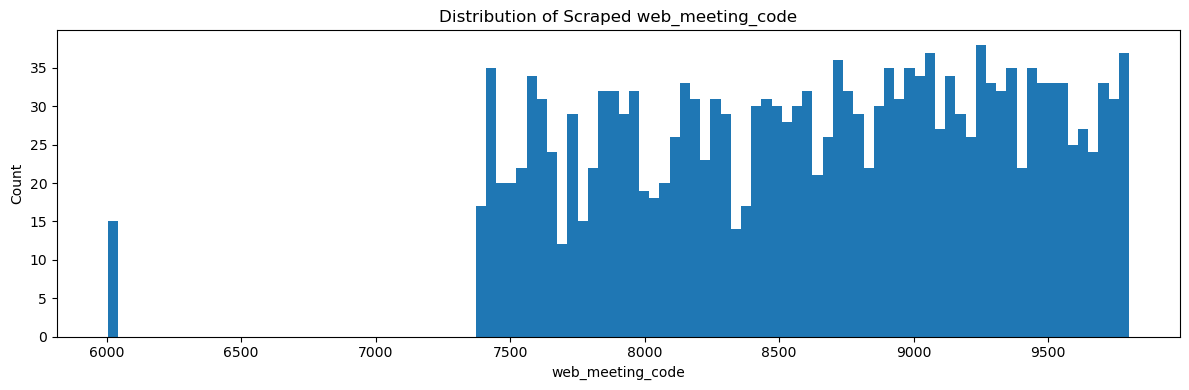

In [510]:
codes = data['web_meeting_code'].dropna().astype(int)
code_range = pd.Series(range(codes.min(), codes.max() + 1))

missing_codes = code_range[~code_range.isin(codes)]
print(f"Missing codes: {len(missing_codes)}")

plt.figure(figsize=(12, 4))
codes.plot(kind='hist', bins=100)
plt.title('Distribution of Scraped web_meeting_code')
plt.xlabel('web_meeting_code')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_44836/1028356808.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data['scrape_minute'] = data['scrape_timestamp'].dt.floor('T')
/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_44836/1028356808.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=data['scrape_minute'].min(),


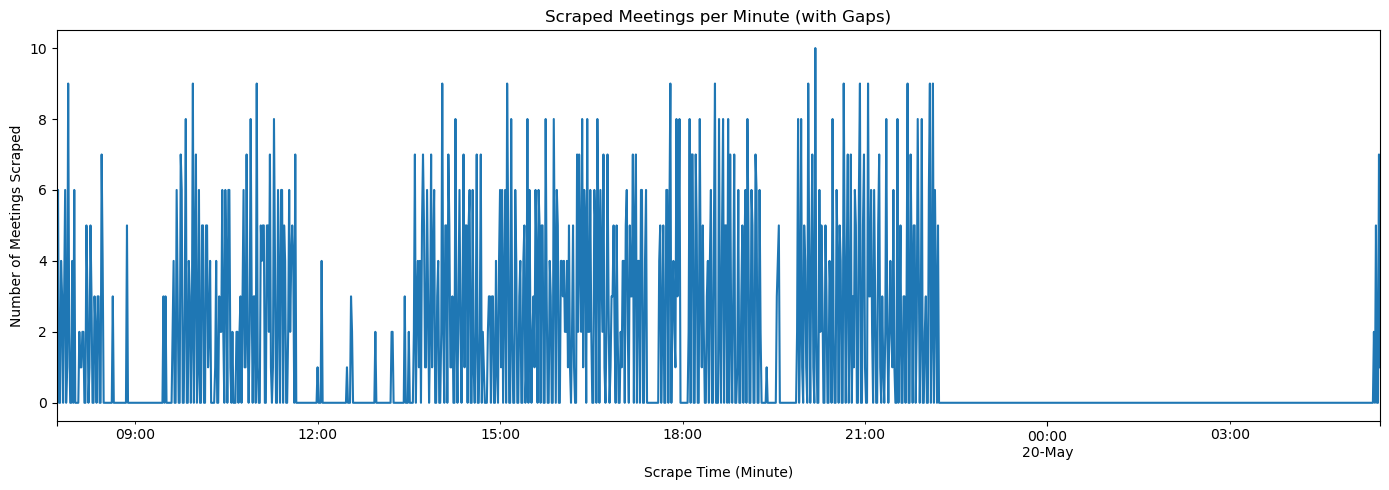

In [511]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to datetime
data['scrape_timestamp'] = pd.to_datetime(data['scrape_timestamp'], errors='coerce')

# Floor to minute
data['scrape_minute'] = data['scrape_timestamp'].dt.floor('T')

# Count scrapes per minute
scrape_counts = data['scrape_minute'].value_counts().sort_index()

# Create full range of minutes between first and last scrape
full_range = pd.date_range(start=data['scrape_minute'].min(),
                           end=data['scrape_minute'].max(),
                           freq='T')

# Reindex with full range, fill missing with 0
scrape_counts_full = scrape_counts.reindex(full_range, fill_value=0)

# Plot
plt.figure(figsize=(14, 5))
scrape_counts_full.plot()
plt.title('Scraped Meetings per Minute (with Gaps)')
plt.xlabel('Scrape Time (Minute)')
plt.ylabel('Number of Meetings Scraped')
plt.tight_layout()
plt.show()

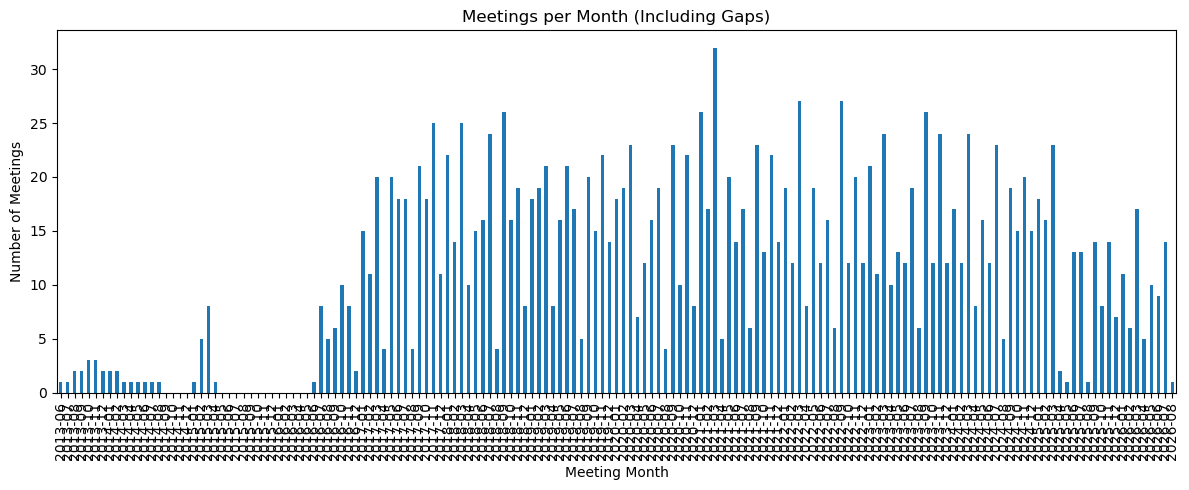

In [512]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert and extract meeting_month
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')
data['meeting_month'] = data['meeting_date'].dt.to_period('M')

# Count meetings per month
monthly_counts = data['meeting_month'].value_counts().sort_index()

# Create full continuous monthly index
full_index = pd.period_range(start=data['meeting_month'].min(),
                             end=data['meeting_month'].max(),
                             freq='M')

# Reindex to ensure gaps are shown with 0s
monthly_counts_full = monthly_counts.reindex(full_index, fill_value=0)

# Plot
plt.figure(figsize=(12, 5))
monthly_counts_full.plot(kind='bar')
plt.title('Meetings per Month (Including Gaps)')
plt.xlabel('Meeting Month')
plt.ylabel('Number of Meetings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [513]:
missing_months = data[data['meeting_month'].isna()]
#missing_months.sample(2)

In [514]:
missing_month_count = data['meeting_month'].isna().sum()
print(f"Missing meeting_month values: {missing_month_count}")

Missing meeting_month values: 0


In [515]:
missing_dates = data[data['meeting_date'].isna()]
missing_dates[['meeting_id', 'meeting_title', 'committee_name', 'meeting_date']]

,meeting_id,meeting_title,committee_name,meeting_date


In [516]:
# Define the fields you consider essential
essential_fields = ['meeting_title', 'meeting_status', 'committee_name', 'meeting_date', 'meeting_time', 'agenda_items']

# Filter rows where web_meeting_code exists AND any essential field is missing
incomplete_rows = data[
    data['web_meeting_code'].notna() & 
    data[essential_fields].isnull().any(axis=1)
]

print(len(incomplete_rows))
incomplete_rows

0


,web_meeting_code,meeting_id,scrape_timestamp,error,meeting_title,meeting_status,committee_name,meeting_date,meeting_time,agenda_items,header_pdf_urls,attached_pdfs,header_pdfs,total_pdfs_found,pdfs_unassigned,pdf_attachment_ok,scrape_minute,meeting_month


In [517]:
rerun = incomplete_rows['web_meeting_code'].to_list()
rerun

[]

In [518]:
import pandas as pd

# Ensure codes are integers and sorted
codes = data['web_meeting_code'].dropna().astype(int)
all_codes = pd.Series(range(codes.min(), codes.max() + 1))

# Identify missing codes
missing_codes = all_codes[~all_codes.isin(codes)]

# Group into consecutive ranges
gap_ranges = []
if not missing_codes.empty:
    start = prev = missing_codes.iloc[0]
    for code in missing_codes[1:]:
        if code == prev + 1:
            prev = code
        else:
            gap_ranges.append((start, prev))
            start = prev = code
    gap_ranges.append((start, prev))  # add final group

# Create DataFrame of missing ranges
missing_df = pd.DataFrame(gap_ranges, columns=['missing_start', 'missing_end'])
missing_df['missing_count'] = missing_df['missing_end'] - missing_df['missing_start'] + 1

missing_df.sort_values(by=['missing_count'], ascending=False).head(15)

,missing_start,missing_end,missing_count
4,6030,7378,1349
92,8002,8023,22
135,8329,8347,19
52,7690,7701,12
61,7765,7776,12
31,7534,7543,10
105,8083,8092,10
285,9669,9678,10
204,8838,8847,10
120,8213,8221,9


In [519]:
# Ensure meeting_date is datetime
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Create a Year-Month string column
data['year_month'] = data['meeting_date'].dt.to_period('M').astype(str)

# Group by year_month and get min, max, and count of web_meeting_code
grouped = data.groupby('year_month')['web_meeting_code'].agg(['min', 'max', 'count']).reset_index()

# Sort by month
grouped = grouped.sort_values('year_month')
grouped.tail(10)

,year_month,min,max,count
132,2025-11,9679,9799,14
133,2025-12,9660,9800,7
134,2026-01,9685,9791,11
135,2026-02,9665,9777,6
136,2026-03,9661,9797,17
137,2026-04,9667,9770,5
138,2026-05,9662,9793,10
139,2026-06,9693,9794,9
140,2026-07,9663,9795,14
141,2026-08,9774,9774,1


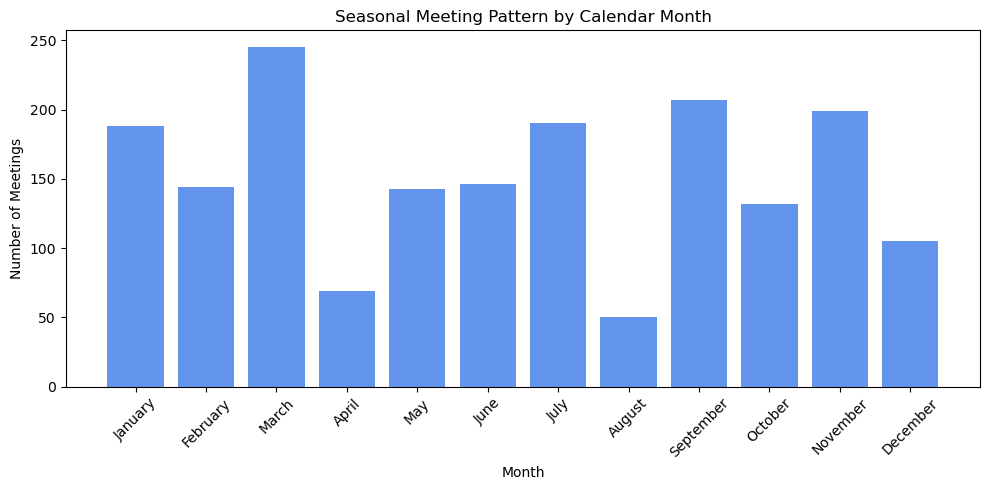

In [520]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime is parsed
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Extract numeric month (1–12) and month name
data['month'] = data['meeting_date'].dt.month
data['month_name'] = data['meeting_date'].dt.month_name()

# Group by month number and count meetings
monthly_pattern = data.groupby(['month', 'month_name']).size().reset_index(name='count')

# Sort by calendar order
monthly_pattern = monthly_pattern.sort_values('month')

# Plot
plt.figure(figsize=(10, 5))
plt.bar(monthly_pattern['month_name'], monthly_pattern['count'], color='cornflowerblue')
plt.title('Seasonal Meeting Pattern by Calendar Month')
plt.xlabel('Month')
plt.ylabel('Number of Meetings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [521]:
# Show a few non-empty agenda items
data['agenda_items'].dropna().iloc[0:1].tolist()

[[{'item_number': '1',
   'item_title': 'Substitutes',
   'sub_items': [{'title': 'Additional documents:',
     'content': 'Webcast for 1.',
     'pdf_urls': []}],
   'pdf_urls': []},
  {'item_number': '2',
   'item_title': 'Declarations of Interest on any items on this agenda',
   'sub_items': [{'title': 'Additional documents:',
     'content': 'Webcast for 2.',
     'pdf_urls': []}],
   'pdf_urls': []},
  {'item_number': '3',
   'item_title': 'Minutes - 22 May 2015PDF 65 KB',
   'sub_items': [{'title': 'Additional documents:',
     'content': 'Webcast for 3.',
     'pdf_urls': []}],
   'pdf_urls': ['https://democracy.kent.gov.uk/documents/s67450/Minutes of Previous Meeting.pdf']},
  {'item_number': '4',
   'item_title': 'Motion to Exclude the Press and Public',
   'sub_items': [{'title': 'Additional documents:',
     'content': 'Webcast for 4.',
     'pdf_urls': []}],
   'pdf_urls': []},
  {'item_number': '5',
   'item_title': 'County Returning Officer',
   'sub_items': [],
   'pdf_u

#### Cleanup of junk pdf scraping results

In [522]:
import re

def clean_item_title(title):
    if isinstance(title, str):
        return re.sub(r'\s*PDF\s*\d+(\.\d+)?\s*(KB|MB)', '', title, flags=re.IGNORECASE).strip()
    return title

def clean_agenda_items(items):
    if isinstance(items, list):
        for item in items:
            if isinstance(item, dict) and 'item_title' in item:
                item['item_title'] = clean_item_title(item['item_title'])
    return items

# Apply cleaning to the full DataFrame
data['agenda_items'] = data['agenda_items'].apply(clean_agenda_items)

#### Explore agendas

In [523]:
#### code to explode 3 tier structure - new scraping code

import pandas as pd
import json

def flatten_agenda_from_df(data):
    # Step 1: Explode agenda_items so each item gets its own row
    agenda_data = data.explode('agenda_items').dropna(subset=['agenda_items']).copy()
    agenda_items_df = pd.json_normalize(agenda_data['agenda_items'])

    # Step 2: Merge back meeting context
    agenda_items_df['meeting_id'] = agenda_data['meeting_id'].values
    agenda_items_df['committee_name'] = agenda_data['committee_name'].values
    agenda_items_df['meeting_date'] = agenda_data['meeting_date'].values
    agenda_items_df['web_meeting_code'] = agenda_data['web_meeting_code'].values

    # OPTIONAL: Append meeting-wide QA flags to every row
    agenda_items_df['pdf_attachment_ok'] = agenda_data.get('pdf_attachment_ok', False).values
    agenda_items_df['attached_pdfs'] = agenda_data.get('attached_pdfs', 0).values
#    agenda_items_df['pdfs_unassigned'] = agenda_data.get('pdfs_unassigned', 0).values

    # Step 3: Explode sub_items (if any)
    agenda_items_df['sub_items'] = agenda_items_df.get('sub_items', None)
    agenda_items_df = agenda_items_df.explode('sub_items')

    # Step 4: Fill sub_item fields (or fallback to item level)
    agenda_items_df['sub_item_content'] = agenda_items_df['sub_items'].apply(
        lambda x: x.get('title') if isinstance(x, dict) else None
    )
    agenda_items_df['item_text'] = agenda_items_df['sub_items'].apply(
        lambda x: x.get('content') if isinstance(x, dict) else None
    )

    agenda_items_df['item_text'] = agenda_items_df['item_text'].fillna(agenda_items_df.get('content', ''))
    agenda_items_df['pdf_urls'] = agenda_items_df.apply(
        lambda row: row['sub_items'].get('pdf_urls') if isinstance(row['sub_items'], dict) and row['sub_items'].get('pdf_urls') else row.get('pdf_urls', []),
        axis=1
    )

    # Final output
    agenda_flat = agenda_items_df[[
        'meeting_id', 'committee_name', 'meeting_date', 'web_meeting_code',
        'item_number', 'item_title', 'item_text', 'pdf_urls', 'sub_item_content'
    ]].copy()

    return agenda_flat

# Usage
agenda_flat = flatten_agenda_from_df(data)

In [524]:
#### code to explode 2 tier structure - the old scraping code

#import pandas as pd

# Explode agenda_items so each item gets its own row
#agenda_data = data.explode('agenda_items').dropna(subset=['agenda_items']).copy()

# Flatten the nested dictionaries into columns
#agenda_flat = pd.json_normalize(agenda_data['agenda_items'])

# Add meeting context to each item
#agenda_flat['meeting_id'] = agenda_data['meeting_id'].values
#agenda_flat['committee_name'] = agenda_data['committee_name'].values
#agenda_flat['meeting_date'] = agenda_data['meeting_date'].values

# Preview
#agenda_flat.head()

In [525]:
agenda_flat.groupby('meeting_id').size().sort_values(ascending=False)

meeting_id
kent_cc_9334    70
kent_cc_8558    49
kent_cc_8985    43
kent_cc_9302    43
kent_cc_8248    42
                ..
kent_cc_7832     1
kent_cc_9105     1
kent_cc_8866     1
kent_cc_7473     1
kent_cc_7847     1
Length: 1407, dtype: int64

In [526]:
agenda_flat['item_title'].str.lower().str.extract(r'(\w+)')[0].value_counts().head(20)

0
appeal          1928
minutes         1719
declarations    1230
apologies       1038
work             639
kent             526
verbal           451
election         365
update           316
performance      286
membership       280
24               237
motion           233
substitutes      204
21               174
draft            163
23               154
19               154
a                153
20               152
Name: count, dtype: int64

In [527]:
# Flatten the list of all pdf URLs
all_pdfs = [url for sublist in agenda_flat['pdf_urls'] if isinstance(sublist, list) for url in sublist]

# Convert to Series for easier analysis
pdf_series = pd.Series(all_pdfs)

# Count total and duplicate entries
total_pdfs = pdf_series.size
unique_pdfs = pdf_series.nunique()
duplicate_pdfs = total_pdfs - unique_pdfs

print(f"Total PDF URLs: {total_pdfs}")
print(f"Unique PDF URLs: {unique_pdfs}")
print(f"Duplicate PDF URLs: {duplicate_pdfs}")

Total PDF URLs: 19300
Unique PDF URLs: 11682
Duplicate PDF URLs: 7618


### New committee cleanup approach

In [528]:
# Count occurrences of each committee_name
committee_counts = data['committee_name'].value_counts(dropna=False)

# Display result
committee_counts.tail(10)

committee_name
(Honorary Alderman), County Council                                                                      1
Budget Meeting - Reserve date, County Council                                                            1
Election of Leader, County Council                                                                       1
Due to lack of quorum informal meeting held, Standing Advisory Council on Religious Education (SACRE)    1
Neighbourhood Forum Grants meeting, Northfleet & Gravesend West Neighbourhood Forum                      1
Neighbourhood Forum Grants meeting, Gravesham East Neighbourhood Forum                                   1
Governor Appointments Panel                                                                              1
Children's Social Care and Health Cabinet Committee                                                      1
Honorary Alderman, County Council                                                                        1
Committee Training, Pe

In [529]:
# Create DataFrame from unique non-null committee names
committee_series = data['committee_name'].dropna().unique()
df_committee_parts = pd.DataFrame({'original_name': committee_series})

# Adjust split logic
df_committee_parts['first_part'] = df_committee_parts['original_name'].apply(
    lambda x: x.rsplit(',', 1)[0] if ',' in x else None
)
df_committee_parts['last_part'] = df_committee_parts['original_name'].apply(
    lambda x: x.rsplit(',', 1)[1].strip() if ',' in x else x
)

df_committee_parts.tail(3)

,original_name,first_part,last_part
81,"Reserve date for Plan and Precept Proposal, Kent and Medway Police and Crime Panel",Reserve date for Plan and Precept Proposal,Kent and Medway Police and Crime Panel
82,"Extraordinary, County Council",Extraordinary,County Council
83,"Committee Training, Pension Fund Committee",Committee Training,Pension Fund Committee


In [530]:
# Define a function to extract the new committee name
def extract_last_part(name):
    if pd.isna(name):
        return name
    return name.rsplit(',', 1)[1].strip() if ',' in name else name

# Apply the transformation back to data, overwriting it
data['committee_name'] = data['committee_name'].apply(extract_last_part)

In [531]:
# Inspect datatypes and nested objects
print(data.dtypes)

# Optional: check a sample problematic row
sample = data.sample(1)
print(sample.to_dict())

web_meeting_code              int64
meeting_id                   object
scrape_timestamp     datetime64[ns]
error                        object
meeting_title                object
meeting_status               object
committee_name               object
meeting_date         datetime64[ns]
meeting_time         datetime64[ns]
agenda_items                 object
header_pdf_urls              object
attached_pdfs               float64
header_pdfs                 float64
total_pdfs_found            float64
pdfs_unassigned             float64
pdf_attachment_ok           float64
scrape_minute        datetime64[ns]
meeting_month             period[M]
year_month                   object
month                         int32
month_name                   object
dtype: object
{'web_meeting_code': {567: 7943}, 'meeting_id': {567: 'kent_cc_7943'}, 'scrape_timestamp': {567: Timestamp('2025-05-19 11:24:21.105141')}, 'error': {567: None}, 'meeting_title': {567: 'Regulation Committee Appeal Panel (Transport)

### New agenda cleanup approach

Cell 1: Clean PDF garbage from titles

In [532]:
import re

PDF_PATTERN = re.compile(r'\s*PDF\s*\d+(\.\d+)?\s*(KB|MB)', flags=re.IGNORECASE)

agenda_flat['item_title'] = agenda_flat['item_title'].fillna('').apply(
    lambda x: PDF_PATTERN.sub('', x).strip()
)

In [533]:
# Word count from item_text
agenda_flat['word_count'] = agenda_flat['item_text'].fillna('').apply(lambda x: len(str(x).split()))

# Count number of PDFs in the list
agenda_flat['pdf_count'] = agenda_flat['pdf_urls'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [534]:
agenda_flat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20430 entries, 0 to 12809
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   meeting_id        20430 non-null  object        
 1   committee_name    20430 non-null  object        
 2   meeting_date      20430 non-null  datetime64[ns]
 3   web_meeting_code  20430 non-null  int64         
 4   item_number       20430 non-null  object        
 5   item_title        20430 non-null  object        
 6   item_text         20430 non-null  object        
 7   pdf_urls          20430 non-null  object        
 8   sub_item_content  18870 non-null  object        
 9   word_count        20430 non-null  int64         
 10  pdf_count         20430 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 1.9+ MB


Cell 2: Tag low-value items instead of dropping

In [535]:
# Step 1: Start fresh
agenda_flat["category"] = None

# Step 2: Broad pass – assign 'webcast' based on item_text
agenda_flat.loc[
    agenda_flat["item_text"].str.contains(r"\bWebcast for\b", case=False, na=False),
    "category"
] = "webcast"

# Map regex patterns to category labels
CATEGORY_PATTERNS = [
    ('apologies', re.compile(r'(?i)\bapologies\b')),
    ('declarations', re.compile(r'(?i)declaration[s]? of (interest|disclosable|inter)')),
    ('next_meeting', re.compile(r'(?i)date of next meeting')),
    ('exempt_items', re.compile(r'(?i)exempt ')),
    ('work_programme', re.compile(r'(?i)work programme')),
    ('future_meeting', re.compile(r'(?i)future meeting')),
    ('introduction', re.compile(r'(?i)^introduction')),
    ('substitutes', re.compile(r'(?i)substitutes')),
    ('questions', re.compile(r'(?i)questions')),
#    ('tributes', re.compile(r'(?i)tributes')),
    ('appeal', re.compile(r'(?i)appeal ')),
    ('minutes', re.compile(r'(?i)minutes')),
    ('appointments', re.compile(r'(?i)appointment')),
    ('restricted_items', re.compile(r'(?i)restricted')),
    ('election', re.compile(r'(?i)election of')),
    ('future_meeting', re.compile(r'(?i)Date of next')),
    ('exempt_items', re.compile(r'(?i)THE PRESS AND PUBLIC')),
    ('pay_policy', re.compile(r'(?i)pay policy')),
    ('welcome', re.compile(r'(?i)welcome')),
    ('procedural', re.compile(r'(?i)MATTERS FOR DECISION')),  
    ('procedural', re.compile(r'(?i) dates')),  
    ('performance', re.compile(r'(?i)performance report')), 
#    ('discussion', re.compile(r'(?i)verbal updates')),  
    

#    ('online_attendance', re.compile(r'(?i)Virtual Attendance'))
]

# Category assignment function
def classify_category(title):
    title = str(title).lower().strip()
    for label, pattern in CATEGORY_PATTERNS:
        if pattern.search(title):
            return label
    return None  # Explicitly return None if no match

# Apply classification only if category not already set
def classify_category(title):
    title = str(title).lower().strip()
    for label, pattern in CATEGORY_PATTERNS:
        if pattern.search(title):
            return label
    return None  # Do not assign 'discussion' here


# Step 3: Apply regex classification — only overwrite if pattern matches
refined = agenda_flat["item_title"].apply(classify_category)

# Only overwrite where a pattern matched (non-null result)
agenda_flat.loc[refined.notnull(), "category"] = refined[refined.notnull()]

agenda_flat["category"] = agenda_flat["category"].fillna("discussion")


In [536]:
# Sample 2 random rows per category
samples_per_category = (
    agenda_flat
    .groupby('category', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 5), random_state=40))  # Ensures reproducibility
    .loc[:, ['category', 'item_title', 'item_text', 'word_count', 'pdf_urls']]
    .sort_values(by='category')
    .reset_index(drop=True)
)

samples_per_category.to_csv("/Users/lgfolder/Downloads/samples.csv")
samples_per_category

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_44836/1410949791.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), 5), random_state=40))  # Ensures reproducibility


,category,item_title,item_text,word_count,pdf_urls
0,apologies,Apologies and Substitutes,Webcast for 123.,3,[]
1,apologies,Apologies and Substitutes,Webcast for 171.,3,[]
2,apologies,Apologies for Absence/Substitutes,"Mrs Paddison-Chapman chaired the meeting.Apologies for absence were received fromDr Smith, Mr Shepherd and Mrs Burke.\n",16,[]
3,apologies,Apologies and Substitutes,Apologies for absence had been\r\nreceived from Mr A Cook and Mr A Booth.\n,14,[]
4,apologies,Apologies and Substitutes,Webcast for 70.,3,[]
...,...,...,...,...,...
95,work_programme,Work Programme,Webcast for 20.,3,[https://democracy.kent.gov.uk/documents/s115872/Work Programme 2022-23.pdf]
96,work_programme,Work Programme 2020/21,"Item 11 - CYPE CC Work Prog 20-21, item 205.PDF 221 KB\nWebcast for 205.",15,[https://democracy.kent.gov.uk/documents/s98896/Item 11 - CYPE CC Work Prog 20-21.pdf]
97,work_programme,Work Programme and Action Log,"1.Mr Buckland introduced the report and\r\nhighlighted that the four actions added to the Action Log at the\r\nlast meeting had all received a response.2.In\r\nresponse to a question from a Member, Mr Buckland advised that the\r\nfee’s charged by fund managers could be reported as part of\r\nthe annual benchmarking process, and it also formed part of the\r\nInvestment Strategy implementation and Intra Asset Class Review,\r\nthat would be considered later in the agenda.3.RESOLVED to note the work programme and updated\r\naction log.\n",84,[https://democracy.kent.gov.uk/documents/s124382/Report.pdf]
98,work_programme,Work Programme,Webcast for 176.,3,[https://democracy.kent.gov.uk/documents/s106065/HRPH work programme.pdf]


In [537]:
#agenda_flat.loc[agenda_flat['category'] == 'discussion', ['item_title', 'item_text', "word_count", "pdf_urls"]].sample(2)

In [538]:
# Group by category and aggregate
category_counts = agenda_flat.groupby('category').agg(
    count=('category', 'count'),
    avg_word_count=('word_count', 'mean'),
    avg_pdf_count=('pdf_count', 'mean')
).reset_index()

# Optional: round for readability
category_counts['avg_word_count'] = category_counts['avg_word_count'].round(1)
category_counts['avg_pdf_count'] = category_counts['avg_pdf_count'].round(2)

category_counts

,category,count,avg_word_count,avg_pdf_count
0,apologies,1038,14.3,0.00
1,appeal,1926,17.8,0.00
2,appointments,84,71.3,1.08
3,declarations,1296,14.3,0.00
4,discussion,7547,184.9,1.40
5,election,366,21.8,0.01
6,exempt_items,485,55.9,0.01
7,future_meeting,120,15.6,0.01
8,introduction,98,39.7,0.17
9,minutes,1766,21.8,1.09


### 🔍 Embedding Filter Logic for Agenda Items

To ensure high retrieval quality while avoiding noise, only agenda items with meaningful semantic content are selected for embedding. Based on a review of multiple category samples, the following rule-based filter has been adopted:

#### ✅ Categories to Embed
- **discussion** — always embedded
- **appointments** — embedded if `word_count > 10`
- **questions** — embedded if `word_count > 20` or has PDF attachments
- **work_programme** — always embedded
- **appeal** — embedded if `word_count > 5` and item_text includes the word "restricted"
- **declarations** — embedded if `word_count > 50`

#### ❌ Categories to Exclude
All others (e.g. `apologies`, `webcast`, `minutes`, `procedural`, `substitutes`, etc.) are excluded by default.

#### 🏷️ Output
Each row will be annotated with a boolean `embed_status` column, which guides downstream chunking and embedding steps.

In [539]:
def assign_embed_status(row):
    category = row["category"]
    wc = row["word_count"]
    text = str(row["item_text"]).lower()
    has_pdf = isinstance(row.get("pdf_urls"), list) and len(row["pdf_urls"]) > 0

    if category == "discussion":
        return True
    if category == "appointments":
        return wc > 10
    if category == "questions":
        return wc > 20 or has_pdf
    if category == "work_programme":
        return True
    if category == "appeal":
        return wc > 5 and "restricted" in text
    if category == "declarations":
        return wc > 50
    return False

# Apply to your agenda metadata dataframe
agenda_flat["embed_status"] = agenda_flat.apply(assign_embed_status, axis=1)

In [540]:
# Match titles that start with any number (with optional decimal), followed by a dot
pattern = r'^\d+(\.\d+)?\.'

matches = agenda_flat[agenda_flat['item_title'].str.match(pattern, na=False)]

# Display useful fields
matches[['item_title', 'item_text', 'meeting_id']]

,item_title,item_text,meeting_id
55,1.,1.,kent_cc_7399
56,2.,2.,kent_cc_7399
63,15.,15.,kent_cc_7405
64,16.,16.,kent_cc_7405
65,17.,17.,kent_cc_7405
...,...,...,...
12794,21.,21.,kent_cc_6023
12795,22.,22.,kent_cc_6023
12796,1.,1.,kent_cc_6024
12797,2.,2.,kent_cc_6024


In [541]:
matches = agenda_flat[agenda_flat['meeting_id'].str.contains('5703', na=False)]

# Display relevant fields
matches[['meeting_id', 'item_number', 'item_title', 'item_text', 'pdf_urls']]

,meeting_id,item_number,item_title,item_text,pdf_urls


In [542]:
import re

def remove_pdf_lines(text):
    if not isinstance(text, str):
        return text
    # Remove any full line containing ".pdf" (case-insensitive), including trailing linebreaks
    cleaned_lines = [
        line for line in text.splitlines()
        if not re.search(r'\.pdf', line, re.IGNORECASE)
    ]
    return "\n".join(cleaned_lines).strip()

# Apply to the column
agenda_flat["item_text"] = agenda_flat["item_text"].apply(remove_pdf_lines)

In [543]:
agenda_flat[agenda_flat["item_text"].str.contains(r'\.pdf', case=False, na=False)].head(5)

,meeting_id,committee_name,meeting_date,web_meeting_code,item_number,item_title,item_text,pdf_urls,sub_item_content,word_count,pdf_count,category,embed_status


In [544]:
agenda_flat[agenda_flat["category"] == "webcast"].sample(5)

,meeting_id,committee_name,meeting_date,web_meeting_code,item_number,item_title,item_text,pdf_urls,sub_item_content,word_count,pdf_count,category,embed_status
3917,kent_cc_8244,Environment & Transport Cabinet Committee,2019-05-24,8244,182,Kent & Medway Energy and Low Emissions Strategy - Draft for Public Consultation,Webcast for 182.,"[https://democracy.kent.gov.uk/documents/s90435/Item 12 - Appendix 1 - KM Energy and Low Emissions Strategy.pdf, https://democracy.kent.gov.uk/documents/s90436/Item 12 - Appendix 2 - KM Energy and Low Emissions Strategy - consultation activity.pdf, https://democracy.kent.gov.uk/documents/s90437/Item 12 - Appendix 3 - KM Energy and Low Emissions Strategy - EQIA.pdf]",Additional documents:,56,3,webcast,False
11892,kent_cc_9508,Scrutiny Committee,2025-01-29,9508,95,Update on the approach to improving the accessibility of schools in Kent,Webcast for 95.,"[https://democracy.kent.gov.uk/documents/s128704/Appendix A Primary-schools-accessibility-information.pdf, https://democracy.kent.gov.uk/documents/s128705/Appendix B Secondary-schools-accessibility-information.pdf]",Additional documents:,17,2,webcast,False
8073,kent_cc_8968,Kent Flood Risk and Water Management Committee,2022-07-05,8968,12,Catchment Management Farming - Presentation by Natural England,Webcast for 12.,[],Additional documents:,3,0,webcast,False
8467,kent_cc_9029,"Annual Meeting, County Council",2023-05-25,9029,145,Report by Leader of the Council (Oral),Webcast for 145.,[],Additional documents:,3,0,webcast,False
9333,kent_cc_9128,Governance and Audit Committee,2023-07-06,9128,126,Independent Member - Term of Office Review,Webcast for 126.,[https://democracy.kent.gov.uk/documents/s119823/Independent Member Role Description.pdf],Additional documents:,11,1,webcast,False


In [545]:
short_items = agenda_flat[agenda_flat['word_count'] < 5]

# Display useful columns
short_items[['item_title', 'item_text', 'word_count', 'category']].sample(10)

,item_title,item_text,word_count,category
4528,Appeal 4,NOT UPHELD,2,appeal
2610,"Capital Programme 2019-22, Revenue Budget 2019-20 and Medium-Term Financial Plan 2019-22",Webcast for 130.,3,webcast
1539,Appeal 10 - 15.30,UPHELD,1,appeal
3731,Apologies and Substitutes,Webcast for 40.,3,apologies
12193,Declarations of Interest,Webcast for 2.,3,declarations
10826,Apologies,Webcast for 1.,3,apologies
312,78.,78.,1,discussion
2815,Minutes of the meeting of the Property Sub-Committee held on 12 April 2018,Webcast for 90.,3,minutes
10434,Minutes,Webcast for 9.,3,minutes
10448,Minutes,Webcast for 3.,3,minutes


Cell 3: Assign fallback item numbers

In [546]:
# Replace missing or blank item_numbers with zero-padded fallback numbers
agenda_flat['item_number'] = agenda_flat['item_number'].fillna('')

agenda_flat['item_number'] = agenda_flat.groupby('meeting_id')['item_number'].transform(
    lambda x: [item if item.strip() else f"{i+1:03d}" for i, item in enumerate(x)]
)

Cell 4: Generate agenda_id

In [547]:
# Step 1: Ensure item_number is a string
agenda_flat['item_number'] = agenda_flat['item_number'].fillna('').astype(str).str.strip()

# Step 2: Sort by meeting_id and item_number alphabetically then numerically
agenda_flat['item_number'] = agenda_flat['item_number'].str.replace(r'[.\s]', '', regex=True)
#agenda_flat['item_number_sort'] = agenda_flat['item_number'].str.extract(r'(\d+)')[0].fillna('').astype(str).str.zfill(3)
#agenda_flat = agenda_flat.sort_values(by=['meeting_id', 'item_number', 'item_number_sort']).reset_index(drop=True)

# Step 3: Assign sequential index within each meeting after sorting
agenda_flat['item_seq'] = agenda_flat.groupby('meeting_id').cumcount() + 1
agenda_flat['item_num_clean'] = agenda_flat['item_seq'].astype(str).str.zfill(3)

# Step 4: Build clean agenda_id
agenda_flat['agenda_id'] = agenda_flat['meeting_id'] + '_' + agenda_flat['item_num_clean']

# Optional: drop the helper column
#agenda_flat.drop(columns=['item_number_sort'], inplace=True)

In [548]:
# Assign machine readable meeting time
#agenda_flat['meeting_date_ts'] = agenda_flat['meeting_date'].astype('int64') // 1_000_000  # milliseconds
#agenda_flat['meeting_date_str'] = agenda_flat['meeting_date'].dt.strftime('%Y-%m-%d')

Reorder columns in agenda_flat

In [549]:
# Desired leading columns
lead_cols = ['meeting_id','agenda_id', 'item_num_clean']#, 'meeting_date_str']

# Get the rest of the columns (preserving order but excluding the leads)
other_cols = [col for col in agenda_flat.columns if col not in lead_cols]

# Reassign agenda_flat with new column order
agenda_flat = agenda_flat[lead_cols + other_cols]

In [550]:
agenda_flat.head(5)

,meeting_id,agenda_id,item_num_clean,committee_name,meeting_date,web_meeting_code,item_number,item_title,item_text,pdf_urls,sub_item_content,word_count,pdf_count,category,embed_status,item_seq
0,kent_cc_7379,kent_cc_7379_001,001,Electoral and Boundary Review Committee,2016-06-22,7379,1,Substitutes,Webcast for 1.,[],Additional documents:,3,0,substitutes,False,1
1,kent_cc_7379,kent_cc_7379_002,002,Electoral and Boundary Review Committee,2016-06-22,7379,2,Declarations of Interest on any items on this agenda,Webcast for 2.,[],Additional documents:,3,0,declarations,False,2
2,kent_cc_7379,kent_cc_7379_003,003,Electoral and Boundary Review Committee,2016-06-22,7379,3,Minutes - 22 May 2015,Webcast for 3.,[https://democracy.kent.gov.uk/documents/s67450/Minutes of Previous Meeting.pdf],Additional documents:,3,1,minutes,False,3
3,kent_cc_7379,kent_cc_7379_004,004,Electoral and Boundary Review Committee,2016-06-22,7379,4,Motion to Exclude the Press and Public,Webcast for 4.,[],Additional documents:,3,0,exempt_items,False,4
4,kent_cc_7379,kent_cc_7379_005,005,Electoral and Boundary Review Committee,2016-06-22,7379,5,County Returning Officer,County Returning Officer,[],None,3,0,discussion,True,5


In [551]:
# Sort agenda items chronologically and by item within each meeting
agenda_flat = agenda_flat.sort_values(by=['meeting_date', 'agenda_id'], ascending=False).reset_index(drop=True)

In [552]:
assert 'meeting_id' in agenda_flat.columns, "meeting_id is missing!"

In [553]:
agenda_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20430 entries, 0 to 20429
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   meeting_id        20430 non-null  object        
 1   agenda_id         20430 non-null  object        
 2   item_num_clean    20430 non-null  object        
 3   committee_name    20430 non-null  object        
 4   meeting_date      20430 non-null  datetime64[ns]
 5   web_meeting_code  20430 non-null  int64         
 6   item_number       20430 non-null  object        
 7   item_title        20430 non-null  object        
 8   item_text         20430 non-null  object        
 9   pdf_urls          20430 non-null  object        
 10  sub_item_content  18870 non-null  object        
 11  word_count        20430 non-null  int64         
 12  pdf_count         20430 non-null  int64         
 13  category          20430 non-null  object        
 14  embed_status      2043

Cell 5: Save to agenda_items.jsonl

In [554]:
output_path = '../data/metadata/agenda_items.jsonl'
agenda_flat.to_json(output_path, orient='records', lines=True)

print(f"✅ Saved {len(agenda_flat)} agenda items to: {output_path}")

✅ Saved 20430 agenda items to: ../data/metadata/agenda_items.jsonl


### Saving meetings metadata

In [555]:
# Drop agenda_items column (it is now split into agenda_flat)
meetings_df = data.drop(columns=['agenda_items'])

# Optional: sort by meeting_date
meetings_df = meetings_df.sort_values(by='meeting_date').reset_index(drop=True)

In [556]:
meetings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818 entries, 0 to 1817
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   web_meeting_code   1818 non-null   int64         
 1   meeting_id         1818 non-null   object        
 2   scrape_timestamp   1818 non-null   datetime64[ns]
 3   error              0 non-null      object        
 4   meeting_title      1818 non-null   object        
 5   meeting_status     1818 non-null   object        
 6   committee_name     1818 non-null   object        
 7   meeting_date       1818 non-null   datetime64[ns]
 8   meeting_time       1818 non-null   datetime64[ns]
 9   header_pdf_urls    1818 non-null   object        
 10  attached_pdfs      1818 non-null   float64       
 11  header_pdfs        1818 non-null   float64       
 12  total_pdfs_found   1818 non-null   float64       
 13  pdfs_unassigned    1818 non-null   float64       
 14  pdf_atta

In [557]:
meetings_df.sample(2)

,web_meeting_code,meeting_id,scrape_timestamp,error,meeting_title,meeting_status,committee_name,meeting_date,meeting_time,header_pdf_urls,attached_pdfs,header_pdfs,total_pdfs_found,pdfs_unassigned,pdf_attachment_ok,scrape_minute,meeting_month,year_month,month,month_name
1257,9125,kent_cc_9125,2025-05-19 18:32:30.766406,None,"Governance and Audit Committee - Thursday, 26th January, 2023 2.00 pm",scheduled,Governance and Audit Committee,2023-01-26,2025-05-20 14:00:00,[],16.0,0.0,16.0,0.0,1.0,2025-05-19 18:32:00,2023-01,2023-01,1,January
81,7616,kent_cc_7616,2025-05-19 09:57:19.329751,None,"Children's Social Care and Health Cabinet Committee - Monday, 16th January, 2017 9.30 am",scheduled,Children's Social Care and Health Cabinet Committee,2017-01-16,2025-05-20 09:30:00,[],9.0,0.0,9.0,0.0,1.0,2025-05-19 09:57:00,2017-01,2017-01,1,January


In [558]:
# Sort by meeting_date descending (most recent first)
meetings_df = meetings_df.sort_values(by='meeting_date', ascending=False).reset_index(drop=True)

### Saving meetings to json

In [559]:
# Save to JSONL
meetings_path = '../data/metadata/meetings.jsonl'
meetings_df.to_json(meetings_path, orient='records', lines=True)

print(f"✅ Saved {len(meetings_df)} meetings to: {meetings_path}")

OverflowError: Maximum recursion level reached

### Code to delete error rows in the meetings_metadata.json (if corrupted and have errors)

In [ ]:
import pandas as pd
import shutil

# Define paths
source_path = '../data/meetings/meetings_metadata_test_1.jsonl'
backup_path = '../data/meetings/meetings_metadata_test_1_backup.jsonl'

# Step 1: Create backup copy
shutil.copy(source_path, backup_path)

# Step 2: Load data
data = pd.read_json(source_path, lines=True)

# Step 3: Filter out rows where 'error' is not NaN
cleaned_data = data[data['error'].isna()]

# Step 4: Overwrite original file with cleaned data   COMMENT IT OUR WGEN DONE!!!!
#cleaned_data.to_json(source_path, orient='records', lines=True)

print(f"Backup saved to: {backup_path}")
print(f"Cleaned file saved to: {source_path}")

Backup saved to: ../data/meetings/meetings_metadata_test_1_backup.jsonl
Cleaned file saved to: ../data/meetings/meetings_metadata_test_1.jsonl
